# Image Regression

> Biwi Kinect Head Pose dataset
- author: Nenad Bozinovic
- order: 2
- callout-appearance: simple
- image: thumbnail.png
- toc-depth: 2
- date: 2023-03-15

Credits: *Practical Deep Learning for Coders* [book](https://course.fast.ai/Resources/book.html) by Jeremy Howard and Sylvain Gugger.

In [ ]:
#| hide 
!pip install nbdev

In [ ]:
#| hide
from blog import set_env
set_env()
from fastai.vision.all import *
from tips.plot import plot_pil_images
from nbdev.showdoc import *
from PIL import ImageDraw

In this project we'll detect the center of the person's face in the image. We'll use the [Biwi Kinect Head Pose dataset](http://data.nvision2.eecs.yorku.ca/Biwi_HeadPose/) for this task. The dataset contains images of 24 people and coresponding obj files that won't be needed. Each image (*_rgb.jpg*) is annotated with the center of the person's face and the pose of the head (*_pose.txt*). The pose is defined by the rotation of the head around the three axes.

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
path.ls()

(#50) [Path('/notebooks/fastai/data/biwi_head_pose/03.obj'),Path('/notebooks/fastai/data/biwi_head_pose/06'),Path('/notebooks/fastai/data/biwi_head_pose/21'),Path('/notebooks/fastai/data/biwi_head_pose/16.obj'),Path('/notebooks/fastai/data/biwi_head_pose/08'),Path('/notebooks/fastai/data/biwi_head_pose/19'),Path('/notebooks/fastai/data/biwi_head_pose/15'),Path('/notebooks/fastai/data/biwi_head_pose/02.obj'),Path('/notebooks/fastai/data/biwi_head_pose/15.obj'),Path('/notebooks/fastai/data/biwi_head_pose/04')...]

There are total of 15678 images:

In [ ]:
img_files = get_image_files(path)  # same as L(path.glob('**/*_rgb.jpg')) but get_image_files is not implemented as a glob)
img_files

(#15678) [Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00554_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00069_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00262_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00324_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00093_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00313_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00129_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00187_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00278_rgb.jpg'),Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00117_rgb.jpg')...]

In [ ]:
len(list(path.glob('**/*_rgb.jpg')))

15678

An image look like this:

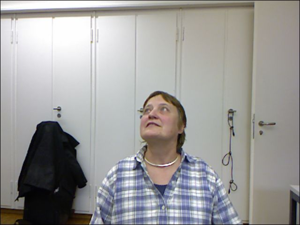

In [ ]:
im_path = (path / '01').ls()[0]
im = PILImage.create(im_path).to_thumb(300)  # same as PIL.Image.open
im

to find the annotation for that image we need to look at the corresponding *_pose.txt* file:


In [ ]:
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

In [ ]:
ff = img2pose(img_files[0])
with open(ff, 'r') as f:
    print(f.read())

0.969581 -0.0117593 0.244489 
-0.0614535 0.955158 0.28965 
-0.236931 -0.295864 0.92538 

22.4063 138.81 1058.77 




The following is the code to extract data from the file, it uses `np.genfromtxt`:

In [ ]:
with open(path / '01' / 'rgb.cal', 'r') as f:
    print(f.read())

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480



The following is the code to extract data from the file, it uses `np.genfromtxt`:

In [ ]:
cal = np.genfromtxt(path / '01' / 'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0]*cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1]*cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])


In [ ]:
img_files[0]

Path('/notebooks/fastai/data/biwi_head_pose/06/frame_00554_rgb.jpg')

In [ ]:
idx = 4
print(img_files[idx])
get_ctr(img_files[idx])

/notebooks/fastai/data/biwi_head_pose/06/frame_00093_rgb.jpg


tensor([367.3590, 311.6036])

We'll use images from person #15 as a validation dataset:

In [ ]:
def splitter(name):
    # True if directory name is 15
    return name.parent.name=='15'

When running with original size it takes ~2.5 minutes per epoch on P5000, which is not super fast. So let's rescale the images to smaller size like half of both width and height, which is [640, 480] / 4 = [160, 120]:

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(splitter),
    batch_tfms=[*aug_transforms(size=[120, 160]), Normalize.from_stats(*imagenet_stats)]
    )

In [ ]:
#| hide
biwi.summary(path)

Setting-up type transforms pipelines
Found 15678 items
2 datasets of sizes 15024,654
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_ctr -> TensorPoint.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /notebooks/fastai/data/biwi_head_pose/06/frame_00554_rgb.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: get_ctr -> TensorPoint.create
    starting from
      /notebooks/fastai/data/biwi_head_pose/06/frame_00554_rgb.jpg
    applying get_ctr gives
      tensor([330.9554, 308.3703])
    applying TensorPoint.create gives
      TensorPoint of size 1x2

Final sample: (PILImage mode=RGB size=640x480, TensorPoint([[330.9554, 308.3703]]))


Found 15678 items
2 datasets of sizes 15024,654
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_ctr -> TensorPoint.create
Setting up after_item: Pipeline: PointScaler -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -

In [ ]:
dls = biwi.dataloaders(path)

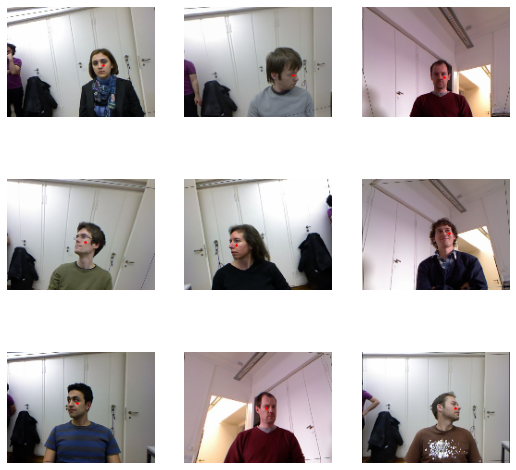

In [ ]:
dls.show_batch(nrows=3, ncols=3)

# Training

Let's look at one batch: 

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 120, 160]), torch.Size([64, 1, 2]))

Let's create a Learner. Because we are dealing with the coordinates as targets, we should rescale them to (-1, 1). If `y_range` is defined then sigmoid is added as a last layer to the model:

In [ ]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.model.state_dict

<bound method Module.state_dict of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

Yup, there it is as a last layer.

FastAI decided on a loss function:

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

this makes sense, we are looking for L2 distance from the target.

Let's take a look at learning rate finder:

SuggestedLRs(valley=0.0012022644514217973)

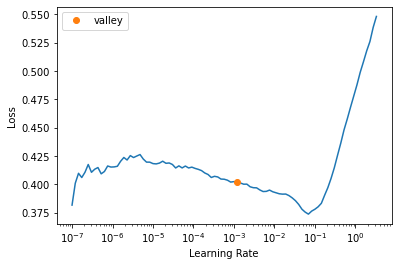

In [ ]:
learn.lr_find()

Let's train:

In [ ]:
learn.fine_tune(5, base_lr=1e-2)

epoch,train_loss,valid_loss,time


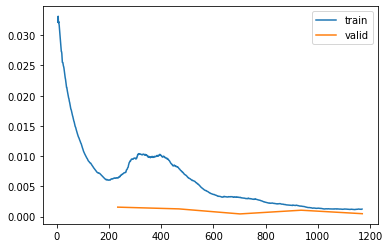

In [ ]:
learn.recorder.plot_loss()

Show predictions on a validation dataset (ds_idx=1, i.e. the validation dataset):

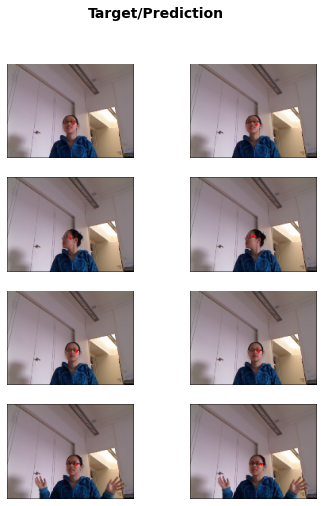

In [ ]:
learn.show_results(ds_idx=1, max_n=4, figsize=(6,8))

In [ ]:
learn.final_record

(#1) [0.00045044912258163095]

The error or 0.00039 is a mean square error, and y_range was (-1, 1) due to sigmoid, where -1 and 1 are the edges of the image (we can't predict outside the images), so this means the corresponds average distance is:

In [ ]:
math.sqrt(0.00039)

0.019748417658131498

This corresponds to an average being 1.5 pixels off from the target (2 is the iamge width : 0.019 = 160 pixels : x):

In [ ]:
0.019*160/2

1.52

# Inference

Let's try to evaluate new images. We need to load RGB images, apparently `learn.predict` applies the same transformation as in `DataLoaders`. It even returns original image if needed (good [post](https://benjaminwarner.dev/2021/10/01/inference-with-fastai) for more info):

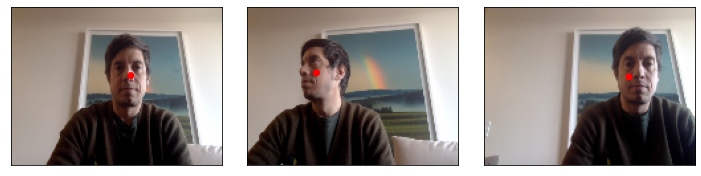

In [ ]:
im_list = [] 
for i in [1,3,4]:
    im_path = f'/notebooks/nbs/mini-projects/15_head_pose/Photo{i}.jpg'
    im_orig, pred, _, _ = learn.predict(im_path, with_input=True)
    point = (pred[0]).detach().cpu().numpy()  # convert predictions to coordinates
    im = ToPILImage()(im_orig/255)
    draw = ImageDraw.Draw(im)
    d = 2
    draw.ellipse((point[0] - d, point[1] - d, point[0] + d, point[1] +d), fill='red')
    im_list.append(im)
_ = plot_pil_images(im_list)

And this is pretty good, even if the head is shifted left and right with respect to the image center.

In [ ]:
#| hide 
# import torchvision
# from torchvision.transforms import Normalize, ToPILImage
# im_raw = PILImage.create(im_path)
# im = im_raw.resize([160,120])
# [*aug_transforms(size=[120, 160]), Normalize.from_stats(*imagenet_stats)]
# im_tensor = torchvision.transforms.ToTensor()(im)
# im_tensor
# im_tensor_norm = Normalize.from_stats(*imagenet_stats)(im_tensor.unsqueeze(0))
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# im_tensor = im_tensor.to(device)